In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import json
import seaborn as sns

from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')

# Analysis of results

## Import of data

In [6]:
DATE = "2021-05-10"


def import_native_and_bytecode(filename):
    native = []
    bytecode = []
    with open(filename) as f:
        for line in f:
            entry = json.loads(line)
            name_sections = list(entry['name'].split('.'))
            if name_sections[0].endswith('bytecode'):
                name_sections[0] = name_sections[0][:-9]
                entry['name'] = '.'.join(name_sections)
                bytecode.append(entry)
            else:
                native.append(entry)
    return pd.json_normalize(native), pd.json_normalize(bytecode)


def import_just_bytecode(filename):
    data = []
    for line in open(filename):
        entry = json.loads(line)
        name_sections = list(entry['name'].split('.'))
        name_sections[0] = name_sections[0][:-9]
        entry['name'] = '.'.join(name_sections)
        data.append(entry)
    return pd.json_normalize(data)
            
    
optimised = import_just_bytecode(f'{DATE}/4.11.1+jit+cranelift50.orun.bench')
initial = import_just_bytecode(f'{DATE}/4.11.1+jit.orun.bench')
native, stock = import_native_and_bytecode(f'{DATE}/4.11.1+stock.orun.bench')

In [7]:
def add_suffix(df, suffix):
    return df.add_suffix(suffix).rename(columns={f'name{suffix}': 'name'})


OLD_DATE = "2020-12-17"
def get_old():
    native, stock = import_native_and_bytecode(f'{OLD_DATE}/4.11.1+stock.orun.bench')
    jit = import_just_bytecode(f'{OLD_DATE}/4.11.1+jit.orun.bench')
    combined = (
        add_suffix(native, '_old_native')
        .merge(add_suffix(stock, '_old_stock'), on='name')
        .merge(add_suffix(jit, '_old_jit'), on='name')
    )[['name', 'time_secs_old_native', 'time_secs_old_stock','time_secs_old_jit']]
    return combined

old = get_old()
old = old[old['name'].isin(optimised['name'])].reset_index()

In [8]:

combined = (
    add_suffix(optimised, '_optimised')
    .merge(add_suffix(native, '_native'), on='name')
    .merge(add_suffix(stock, '_stock'), on='name')
    .merge(add_suffix(initial, '_initial'), on='name')
)[['name', 'time_secs_native', 'time_secs_stock', 'time_secs_initial', 'time_secs_optimised']]
combined = combined.merge(old, on='name')
combined['optimised_stock_speedup'] = combined.time_secs_stock / combined.time_secs_optimised
combined['initial_stock_speedup'] = combined.time_secs_stock / combined.time_secs_initial
combined['optimised_initial_speedup'] = combined.time_secs_initial / combined.time_secs_optimised
combined['native_optimised_speedup'] = combined.time_secs_optimised / combined.time_secs_native
combined['old_stock_speedup'] = combined.time_secs_old_stock / combined.time_secs_old_jit

combined = combined.sort_values(by='optimised_stock_speedup', ascending=False).reset_index(drop=True)
print(combined.to_string())

                                         name  time_secs_native  time_secs_stock  time_secs_initial  time_secs_optimised  index  time_secs_old_native  time_secs_old_stock  time_secs_old_jit  optimised_stock_speedup  initial_stock_speedup  optimised_initial_speedup  native_optimised_speedup  old_stock_speedup
0                  chameneos_redux_lwt.600000          0.842319         6.993340           3.241840             3.178341     34              0.832997             7.115391           3.099997                 2.200311               2.157213                   1.019979                  3.773322           2.295290
1                             binarytrees5.21          5.289864        19.926523          13.075403             9.268170     31              5.227178            19.891920          11.249499                 2.149995               1.523970                   1.410786                  1.752062           1.768249
2                            pidigits5.10_000          2.297901       

In [9]:
combined['optimised_stock_speedup'].describe()

count    36.000000
mean      1.461318
std       0.403901
min       0.813705
25%       1.155861
50%       1.361486
75%       1.672978
max       2.200311
Name: optimised_stock_speedup, dtype: float64

In [10]:
combined['initial_stock_speedup'].describe()

count    36.000000
mean      1.275304
std       0.282836
min       0.843715
25%       1.112389
50%       1.199408
75%       1.360729
max       2.157213
Name: initial_stock_speedup, dtype: float64

In [11]:
combined['optimised_initial_speedup'].describe()

count    36.000000
mean      1.147777
std       0.228529
min       0.856682
25%       1.006330
50%       1.076382
75%       1.284423
max       2.033881
Name: optimised_initial_speedup, dtype: float64

In [12]:
combined['old_stock_speedup'].describe()

count    36.000000
mean      1.358036
std       0.310417
min       0.703732
25%       1.188121
50%       1.343302
75%       1.484232
max       2.295290
Name: old_stock_speedup, dtype: float64

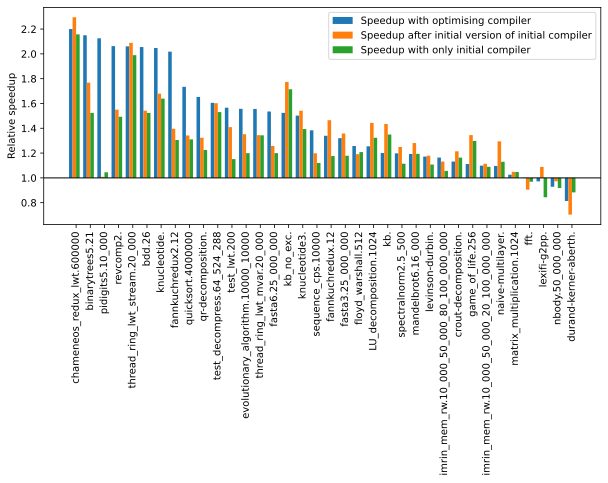

In [13]:
plt.figure(figsize=(10, 4))
x = np.arange(len(combined))
barwidth = 0.25
plt.xticks(x, combined['name'], rotation='vertical')
plt.bar(x - barwidth * 1.5, combined['optimised_stock_speedup'] - 1, width=barwidth, bottom=1, label='Speedup with optimising compiler')
plt.bar(x - barwidth * 0.5, combined['old_stock_speedup'] - 1, width=barwidth, bottom=1, label='Speedup after initial version of initial compiler')
plt.bar(x + barwidth * 0.5, combined['initial_stock_speedup'] - 1, width=barwidth, bottom=1, label='Speedup with only initial compiler')
plt.axhline(1, color='black', lw=1)
plt.ylabel('Relative speedup')
plt.legend()
plt.savefig('../../docs/images/perf.pdf', bbox_inches='tight')  

In [14]:
# fig, axs = plt.subplots(nrows=3, sharex=True, figsize=(10, 10))
# axs[0].hist(combined['optimised_stock_speedup'])
# axs[0].tick_params(axis='x', labelbottom=True)
# axs[1].hist(combined['old_stock_speedup'])
# axs[1].tick_params(axis='x', labelbottom=True)
# axs[2].hist(combined['initial_stock_speedup'])

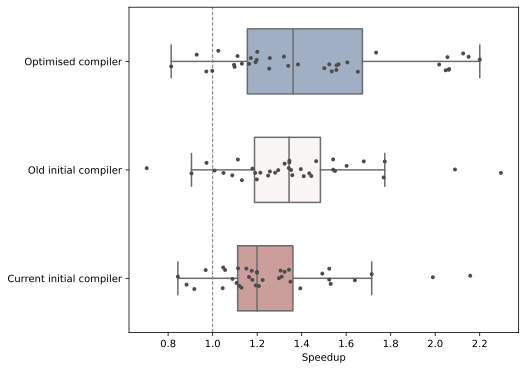

In [15]:
f, ax = plt.subplots(figsize=(7, 6))
data = combined[['optimised_stock_speedup', 'old_stock_speedup', 'initial_stock_speedup']]
data.columns = ['Optimised compiler', 'Old initial compiler', 'Current initial compiler']
sns.boxplot(data=data, width=.6, palette="vlag", orient='h', showfliers=False)
sns.stripplot(data=data, size=4, color=".3", linewidth=0, orient='h')
plt.axvline(1, linewidth=1, color='gray', linestyle='--')
plt.xlabel('Speedup')
plt.savefig('../../docs/images/box.pdf', bbox_inches='tight')  

In [16]:
data.describe()

,Optimised compiler,Old initial compiler,Current initial compiler
count,36.000000,36.000000,36.000000
mean,1.461318,1.358036,1.275304
std,0.403901,0.310417,0.282836
min,0.813705,0.703732,0.843715
25%,1.155861,1.188121,1.112389
50%,1.361486,1.343302,1.199408
75%,1.672978,1.484232,1.360729
max,2.200311,2.295290,2.157213


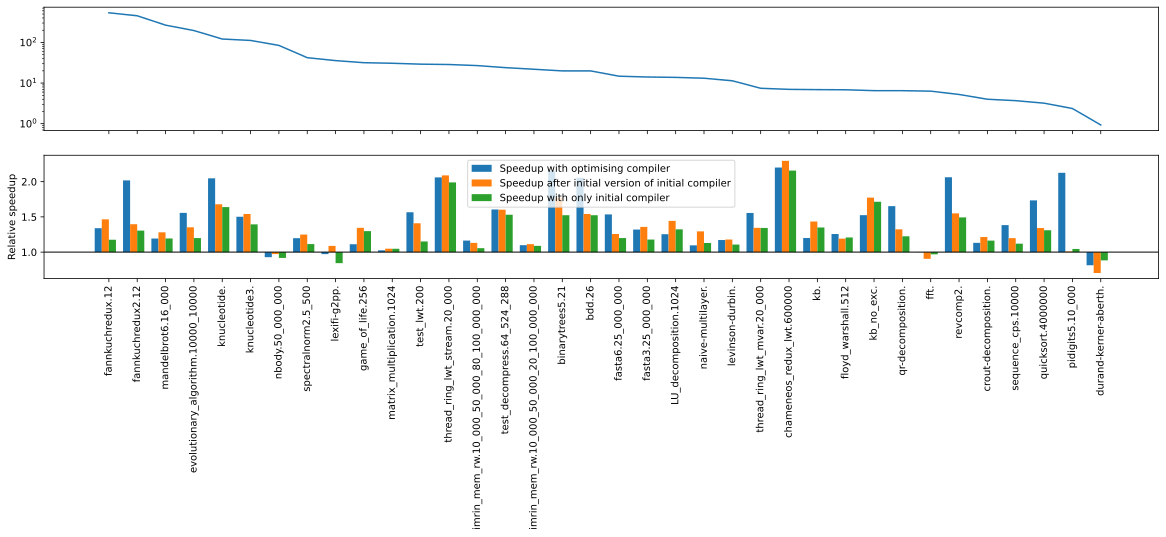

In [104]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(20, 5), sharex=True)

x = np.arange(len(combined))

axs[0].plot(data['time_secs_stock'])
axs[0].set_yscale('log')

barwidth = 0.25
data = combined.sort_values(by='time_secs_stock', ascending=False).reset_index(drop=True)
plt.xticks(x, data['name'], rotation='vertical')
axs[1].bar(x - barwidth * 1.5, data['optimised_stock_speedup'] - 1, width=barwidth, bottom=1, label='Speedup with optimising compiler')
axs[1].bar(x - barwidth * 0.5, data['old_stock_speedup'] - 1, width=barwidth, bottom=1, label='Speedup after initial version of initial compiler')
axs[1].bar(x + barwidth * 0.5, data['initial_stock_speedup'] - 1, width=barwidth, bottom=1, label='Speedup with only initial compiler')
axs[1].axhline(1, color='black', lw=1)
axs[1].set_ylabel('Relative speedup')
plt.legend()

In [110]:
combined['time_secs_stock'].sort_values().reset_index(drop=True)

0       0.929891
1       2.361782
2       3.196483
3       3.685537
4       3.995435
5       5.237281
6       6.317413
7       6.492312
8       6.501795
9       6.832428
10      6.890947
11      6.993340
12      7.436210
13     11.369376
14     13.147983
15     13.794486
16     14.095273
17     14.750086
18     19.912491
19     19.926523
20     21.865958
21     23.955433
22     26.913191
23     28.610724
24     29.193604
25     30.713013
26     31.705854
27     35.699142
28     42.148595
29     84.464603
30    111.968948
31    121.368903
32    196.159054
33    266.473461
34    453.192121
35    536.697978
Name: time_secs_stock, dtype: float64

# len(combined)